In [ ]:
import os
import PIL
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

IMG_DIR = 'images_satellite'       
FEATURE_FILE = 'image_features.csv' 

files = [f for f in os.listdir(IMG_DIR) if f.endswith('.png')]
print(f"WE HAVE {len(files)} PNG images.")

#loading resnet50 model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

#feature extraction
features_list = []

for i, img_file in enumerate(files):
    img_path = os.path.join(IMG_DIR, img_file)
    house_id = img_file.split('.')[0] 

    # Load & Process
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = base_model.predict(x, verbose=0)
    feature_row = features[0].tolist()
    feature_row.insert(0, house_id)
    features_list.append(feature_row)
    if (i+1) % 10 == 0:
        print(f"Processed {i+1}/{len(files)}")

# saving
cols = ['id'] + [f'v_{i}' for i in range(2048)]
features_df = pd.DataFrame(features_list, columns=cols)
features_df['id'] = features_df['id'].astype('int64')
features_df.to_csv(FEATURE_FILE, index=False)
print(f"SAVED! New Shape: {features_df.shape}")

📂 Found folder 'images_satellite'. It contains 9963 PNG images.

Loading ResNet50 Model...
Starting feature extraction...
Processed 10/9963
Processed 20/9963
Processed 30/9963
Processed 40/9963
Processed 50/9963
Processed 60/9963
Processed 70/9963
Processed 80/9963
Processed 90/9963
Processed 100/9963
Processed 110/9963
Processed 120/9963
Processed 130/9963
Processed 140/9963
Processed 150/9963
Processed 160/9963
Processed 170/9963
Processed 180/9963
Processed 190/9963
Processed 200/9963
Processed 210/9963
Processed 220/9963
Processed 230/9963
Processed 240/9963
Processed 250/9963
Processed 260/9963
Processed 270/9963
Processed 280/9963
Processed 290/9963
Processed 300/9963
Processed 310/9963
Processed 320/9963
Processed 330/9963
Processed 340/9963
Processed 350/9963
Processed 360/9963
Processed 370/9963
Processed 380/9963
Processed 390/9963
Processed 400/9963
Processed 410/9963
Processed 420/9963
Processed 430/9963
Processed 440/9963
Processed 450/9963
Processed 460/9963
Processed 470

### CHECKING Model Explainability using Grad-CAM

Scanning image folder...
📂 Found 9963 total images.
✅ Matched 10054 images with CSV.
Loading 2000 images into memory...
✅ Successfully loaded 2000 images.
Training Visualization Helper (Proxy Model)...
Epoch 1/5

63/63 [==============================] - 59s 763ms/step - loss: 15.7638
Epoch 2/5
63/63 [==============================] - 50s 800ms/step - loss: 0.2758
Epoch 3/5
63/63 [==============================] - 50s 798ms/step - loss: 0.2689
Epoch 4/5
63/63 [==============================] - 46s 725ms/step - loss: 0.2667
Epoch 5/5
63/63 [==============================] - 44s 704ms/step - loss: 0.2709
✅ Proxy Model Ready!

Generating Report Visuals...


C:\Users\hp\AppData\Local\Temp\ipykernel_24452\2986331384.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


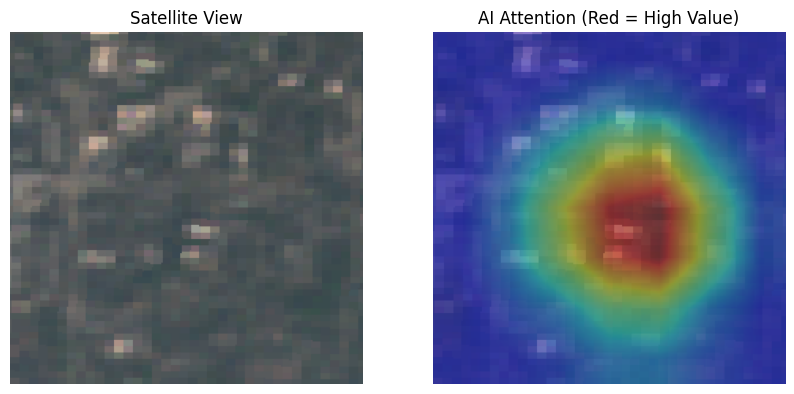

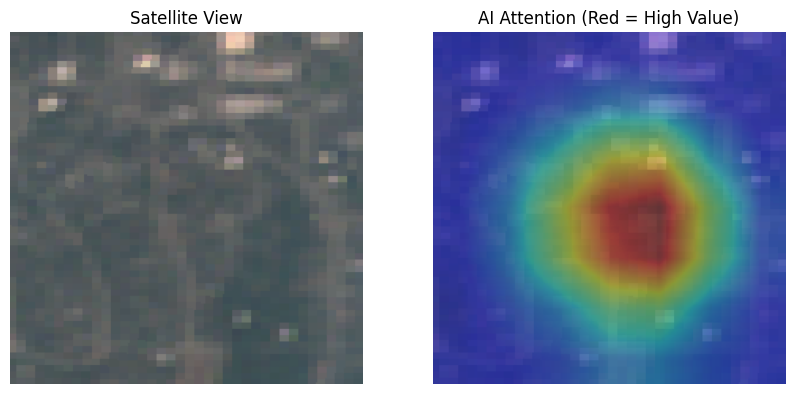

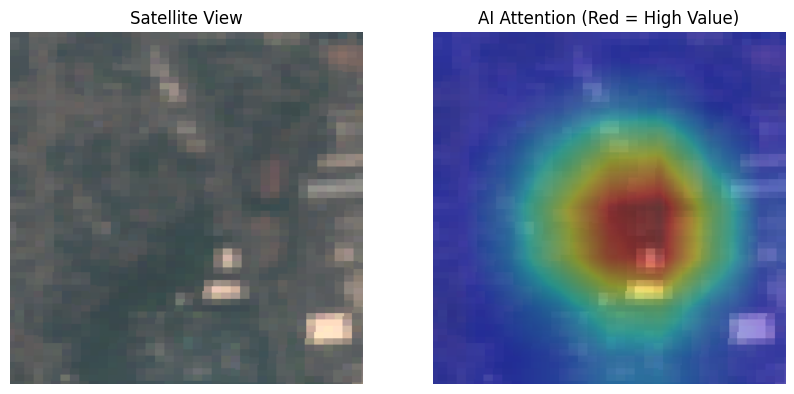

In [ ]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For the heatmap colors
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMG_DIR = 'images_satellite'
IMG_SIZE = (224, 224)
SAMPLE_SIZE = 2000 

all_files = [f for f in os.listdir(IMG_DIR) if f.endswith('.png')]

# Match IDs
available_ids = set([f.split('.')[0] for f in all_files])
df = pd.read_csv('train.csv')
df['id_str'] = df['id'].astype(str)
df_clean = df[df['id_str'].isin(available_ids)].copy()

print(f"Matched {len(df_clean)} images with CSV.")

# Sample
if len(df_clean) > SAMPLE_SIZE:
    df_clean = df_clean.sample(n=SAMPLE_SIZE, random_state=42)

print(f"Loading {len(df_clean)} images into memory")

images = []
prices = []

for index, row in df_clean.iterrows():
    try:
        img_path = os.path.join(IMG_DIR, f"{row['id_str']}.png")
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        img = img.astype(np.float32) / 255.0
        images.append(img)
        prices.append(np.log1p(row['price']))
    except Exception as e:
        continue

X_train = np.array(images)
y_train = np.array(prices)

print(f"Successfully loaded {len(X_train)} images.")

# TRAINING PROXY MODEL
if len(X_train) > 0:
    print("Training Visualization Helper (Proxy Model)...")
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False 

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1)(x) 

    proxy_model = Model(inputs=base_model.input, outputs=predictions)
    proxy_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    proxy_model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1)
    print("Proxy Model Ready")

# GRAD-CAM FUNCTION
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_value = preds[:, 0]

    grads = tape.gradient(pred_value, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    heatmap_img = tf.image.resize(heatmap[..., np.newaxis], (224, 224))
    heatmap_img = tf.squeeze(heatmap_img).numpy()
    heatmap_img = heatmap_img / 255.0 
    jet_heatmap = jet(heatmap_img)[..., :3]

    superimposed_img = jet_heatmap * 0.4 + img * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Satellite View")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("AI Attention (Red = High Value)")
    plt.axis('off')
    plt.show()

if len(X_train) > 0:
    indices = random.sample(range(len(X_train)), 3)
    for idx in indices:
        img_batch = np.expand_dims(X_train[idx], axis=0)
        heatmap = make_gradcam_heatmap(img_batch, proxy_model)
        display_gradcam(X_train[idx], heatmap)